In [1]:
import numpy as np          
import pandas as pd        
import scipy as sp          
import scipy.stats as stats
import scipy.optimize as op
import scipy.signal as sig
import statistics as stat
import os
import datetime
import matplotlib as mpl
import matplotlib.pyplot as plt
import glob           
import math

from scipy.stats import gaussian_kde
from numpy import mean
from statistics import stdev
from numpy.fft import rfft, rfftfreq

import time
import sys
import math
import struct
%matplotlib inline

In [2]:
#
# how to run this
#this analysis is done for janurary data 2015 at apachipoint
#1: you will need the level 1 files in min: you can find it in ap046 > level1 > 2015, the GGP fils in there are in min
#you will need to download it, open it, open the file as txt and save it as txt. 
#2: you will need to load them at the locations shown below, and everything should be done.
#
#wher to find the calibration number to convert V to nms^-2
#you will need to go to ap046 > level 1 folder, there are two calibration files in that folder along with 2009-2018 data folders
#in the file IGETS-SG-CAL-ap046-20210300.cal, you can find the gcal value of -944.3833 on the last row, which was applied since 20130908, that is the one we are using.


## Change all gpp into txt if needed!!

# directory path
path = r'C:\Users\gxy_0\au030\Level3\2020'

# get all .gpp files
gpp_files = glob.glob(os.path.join(path, '*.ggp'))

# rename each file
for gpp_file in gpp_files:
    # generate new file name
    new_file = os.path.splitext(gpp_file)[0] + '.txt'
    
    # rename file
    os.rename(gpp_file, new_file)

In [3]:
file_pattern = r"C:\Users\gxy_0\Schiltach\bf056-1\Level3\2015\*.txt"
file_paths = glob.glob(file_pattern)

lev3_list = []
for file_path in file_paths:
    df = pd.read_csv(file_path, delim_whitespace=True, skiprows=18, names=["yyyymmdd", "hhmmss", "res_fil", "res_nofil", "tides", "rotation", "atm_load", "drift", "g_fil", "p_fil"])
    lev3_list.append(df)

# Concatenate all DataFrames into a single DataFrame
lev3 = pd.concat(lev3_list, ignore_index=True)
lev3

,yyyymmdd,hhmmss,res_fil,res_nofil,tides,rotation,atm_load,drift,g_fil,p_fil
0,20120101,0.0,-11.544,-11.544,-122.629,2.916,2.958,-86.202,-214.501,-0.593
1,20120101,100.0,-11.525,-11.525,-122.829,2.916,2.880,-86.202,-214.760,-0.562
2,20120101,200.0,-11.496,-11.496,-123.032,2.916,2.828,-86.202,-214.987,-0.542
3,20120101,300.0,-11.476,-11.476,-123.240,2.915,2.829,-86.202,-215.174,-0.546
4,20120101,400.0,-11.470,-11.470,-123.452,2.915,2.854,-86.202,-215.355,-0.561
...,...,...,...,...,...,...,...,...,...,...
4207867,20191231,235700.0,9.739,9.739,-461.404,-5.963,-44.365,-99.638,-601.631,14.405
4207868,20191231,235800.0,9.772,9.772,-464.463,-5.964,-44.355,-99.638,-604.647,14.404
4207869,20191231,235900.0,9.757,9.757,-467.513,-5.964,-44.327,-99.638,-607.685,14.395
4207870,88888888,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
df_bad_3 = lev3.loc[(lev3["p_fil"] == 'nan')| (lev3["g_fil"] == 'nan') | (lev3["hhmmss"] == 'nan')| (lev3["yyyymmdd"] == 99999999)| (lev3["yyyymmdd"] == 88888888) ]#find bad column
bad_index_3 = df_bad_3.index.tolist()#make them into list
lev3 = lev3.drop(lev3.index[bad_index_3])#remove bad rows
lev3 = lev3.reset_index()
lev3

,index,yyyymmdd,hhmmss,res_fil,res_nofil,tides,rotation,atm_load,drift,g_fil,p_fil
0,0,20120101,0.0,-11.544,-11.544,-122.629,2.916,2.958,-86.202,-214.501,-0.593
1,1,20120101,100.0,-11.525,-11.525,-122.829,2.916,2.880,-86.202,-214.760,-0.562
2,2,20120101,200.0,-11.496,-11.496,-123.032,2.916,2.828,-86.202,-214.987,-0.542
3,3,20120101,300.0,-11.476,-11.476,-123.240,2.915,2.829,-86.202,-215.174,-0.546
4,4,20120101,400.0,-11.470,-11.470,-123.452,2.915,2.854,-86.202,-215.355,-0.561
...,...,...,...,...,...,...,...,...,...,...,...
4207675,4207865,20191231,235500.0,9.792,9.792,-455.257,-5.963,-44.411,-99.638,-595.477,14.419
4207676,4207866,20191231,235600.0,9.746,9.746,-458.336,-5.963,-44.377,-99.638,-598.568,14.407
4207677,4207867,20191231,235700.0,9.739,9.739,-461.404,-5.963,-44.365,-99.638,-601.631,14.405
4207678,4207868,20191231,235800.0,9.772,9.772,-464.463,-5.964,-44.355,-99.638,-604.647,14.404


In [5]:
print (lev3["hhmmss"])

0               0.0
1             100.0
2             200.0
3             300.0
4             400.0
             ...   
4207675    235500.0
4207676    235600.0
4207677    235700.0
4207678    235800.0
4207679    235900.0
Name: hhmmss, Length: 4207680, dtype: float64


In [6]:
# Assuming 'lev3' is your DataFrame

# Split 'hhmmss' column into separate components
lev3['hours'] = lev3['hhmmss'] // 10000
lev3['minutes'] = (lev3['hhmmss'] // 100) % 100
lev3['seconds'] = lev3['hhmmss'] % 100

# Calculate total minutes
lev3['minutes_only'] = lev3['hours'] * 60 + lev3['minutes']

print(lev3['minutes_only'])

0             0.0
1             1.0
2             2.0
3             3.0
4             4.0
            ...  
4207675    1435.0
4207676    1436.0
4207677    1437.0
4207678    1438.0
4207679    1439.0
Name: minutes_only, Length: 4207680, dtype: float64


In [7]:
# Assuming 'lev3' is your DataFrame

# Convert 'yyyymmdd' column to datetime format
lev3['date'] = pd.to_datetime(lev3['yyyymmdd'], format='%Y%m%d')

# Define the starting date
starting_date = pd.to_datetime('20150101', format='%Y%m%d')

# Calculate the timedelta from the starting date
lev3['elapsed_minutes'] = (lev3['date'] - starting_date).dt.total_seconds() // 60

print(lev3['elapsed_minutes'])

0         -1578240.0
1         -1578240.0
2         -1578240.0
3         -1578240.0
4         -1578240.0
             ...    
4207675    2628000.0
4207676    2628000.0
4207677    2628000.0
4207678    2628000.0
4207679    2628000.0
Name: elapsed_minutes, Length: 4207680, dtype: float64


In [8]:
lev3

,index,yyyymmdd,hhmmss,res_fil,res_nofil,tides,rotation,atm_load,drift,g_fil,p_fil,hours,minutes,seconds,minutes_only,date,elapsed_minutes
0,0,20120101,0.0,-11.544,-11.544,-122.629,2.916,2.958,-86.202,-214.501,-0.593,0.0,0.0,0.0,0.0,2012-01-01,-1578240.0
1,1,20120101,100.0,-11.525,-11.525,-122.829,2.916,2.880,-86.202,-214.760,-0.562,0.0,1.0,0.0,1.0,2012-01-01,-1578240.0
2,2,20120101,200.0,-11.496,-11.496,-123.032,2.916,2.828,-86.202,-214.987,-0.542,0.0,2.0,0.0,2.0,2012-01-01,-1578240.0
3,3,20120101,300.0,-11.476,-11.476,-123.240,2.915,2.829,-86.202,-215.174,-0.546,0.0,3.0,0.0,3.0,2012-01-01,-1578240.0
4,4,20120101,400.0,-11.470,-11.470,-123.452,2.915,2.854,-86.202,-215.355,-0.561,0.0,4.0,0.0,4.0,2012-01-01,-1578240.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4207675,4207865,20191231,235500.0,9.792,9.792,-455.257,-5.963,-44.411,-99.638,-595.477,14.419,23.0,55.0,0.0,1435.0,2019-12-31,2628000.0
4207676,4207866,20191231,235600.0,9.746,9.746,-458.336,-5.963,-44.377,-99.638,-598.568,14.407,23.0,56.0,0.0,1436.0,2019-12-31,2628000.0
4207677,4207867,20191231,235700.0,9.739,9.739,-461.404,-5.963,-44.365,-99.638,-601.631,14.405,23.0,57.0,0.0,1437.0,2019-12-31,2628000.0
4207678,4207868,20191231,235800.0,9.772,9.772,-464.463,-5.964,-44.355,-99.638,-604.647,14.404,23.0,58.0,0.0,1438.0,2019-12-31,2628000.0


In [10]:
debil = lev3['g_fil']

#making the PSD for level 1
#I look at what abby have done, i think i have copied it correctly
N = len(debil)  # number of measurements
samplingRate = 1/60  # once per min sampling rate

# compute the PSD
PSDV = np.abs(np.fft.rfft(debil))**2 / (N*samplingRate)
# PSDV = np.abs(np.fft.rfft(lev1['gravity(V)']))**2 / N
PSDG = (np.abs(rfft(debil))**2)*2/(N*samplingRate)
freq = np.fft.rfftfreq(N, d=1/samplingRate)
N



4207680

In [11]:
debil_h = debil * np.hanning(N) #this is the hanning filtered data
FAS = np.abs(np.fft.rfft(debil_h))
FAS



array([1.40178662e+08, 6.27877604e+07, 1.27696402e+07, ...,
       5.83279337e+00, 4.38375921e+00, 4.14862241e+00])

C:\Users\gxy_0\AppData\Local\Temp\ipykernel_5556\1595870121.py:17: RuntimeWarning: divide by zero encountered in divide
  T_coherent = 1e6 / freq


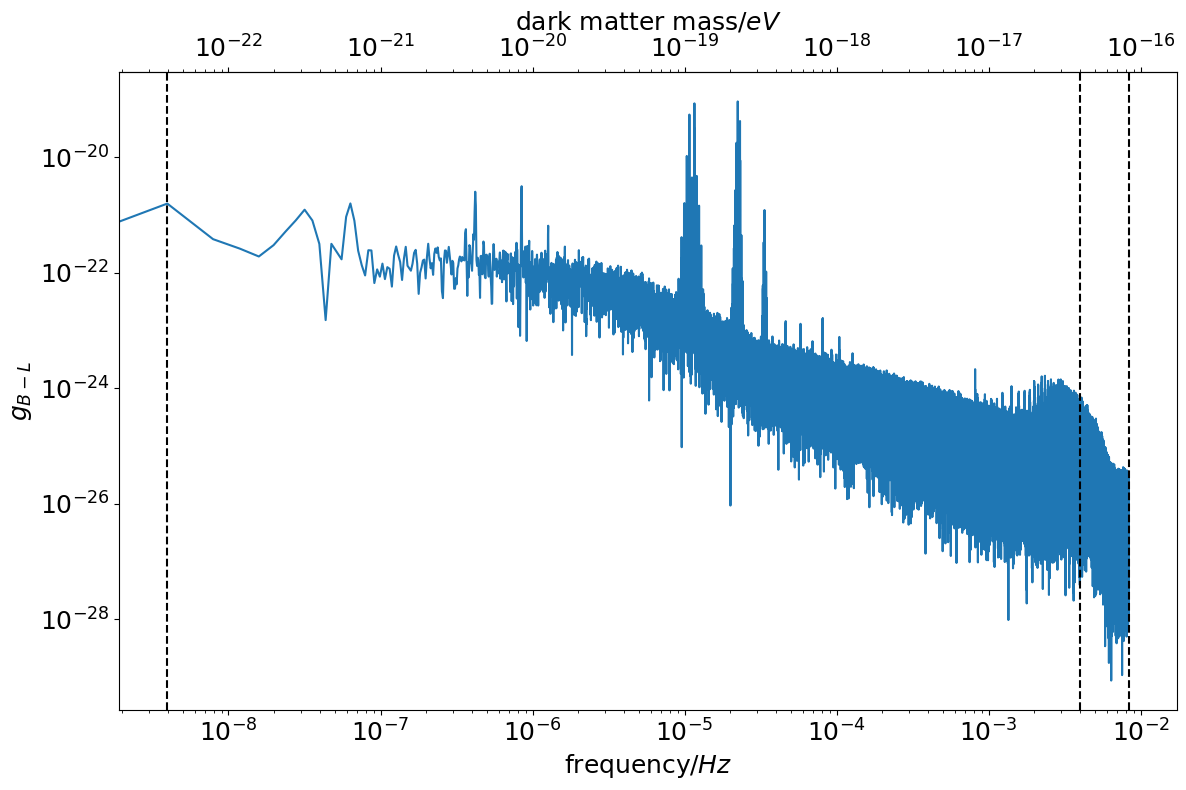

In [14]:
#This is going to use the debil_h, hanning filtered PSD

# Compute PSD
fft_values = np.fft.rfft(debil_h)
psd_values = np.abs(fft_values) ** 2 / (N * samplingRate)
frequencies = np.fft.rfftfreq(N, d=1/samplingRate)

# Assign PSD values to S and frequencies to freq
S = psd_values
freq = frequencies

# Constants
m_neutron = 1.675e-27  # Mass of neutron in kilograms
F_0 = 1e-15

# Do g_B-L transformation

def g_B_L(S, freq):
    T_coherent = 1e6 / freq
    T_integration = 252460680
    T_effective = np.where(T_coherent < T_integration, T_integration, np.sqrt(T_coherent * T_integration))
    return (2 * m_neutron / F_0) * np.sqrt(S * 1e-18 / T_effective)

g = g_B_L(S,freq)

fig, ax1 = plt.subplots(figsize=(12, 8))

# Plotting on the first y-axis and first x-axis
ax1.plot(freq, g, label='y=3e-17')
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlabel(r'frequency$/Hz$', fontsize=18)
ax1.set_ylabel(r'$g_{B-L}$', fontsize=18)
ax1.tick_params('x',labelsize=18)
ax1.tick_params('y',labelsize=18)

# Define forward and inverse transformations for x2 and y2
def forward_x2_transform(x):
    return x * 1e-14

def inverse_x2_transform(x):
    return x / 1e-14

# Create secondary x and y axes
secax_x = ax1.secondary_xaxis('top', functions=(forward_x2_transform, inverse_x2_transform))

# For the secondary x-axis label and tick parameters
secax_x.set_xlabel(r'dark matter mass$/eV$', fontsize=18)
secax_x.tick_params(axis='x', labelsize=18)


# Define cut-off x-axis values
cut_off2 = 1/60 *0.5
cut_off1 = 1/252460680
cut1 = 10**6 / 252460680

# Add vertical dotted lines at cut-off x-axis values
ax1.axvline(cut_off2, color='k', linestyle='--')
ax1.axvline(cut_off1, color='k', linestyle='--')
ax1.axvline(cut1, color='k', linestyle='--')


plt.tight_layout()  # adjust layout for better appearance
plt.show()

file_path = "gvfdata_7.txt"
np.savetxt(file_path, np.column_stack([freq, g]), header="Frequency\tg_B-L", delimiter="\t")

C:\Users\gxy_0\AppData\Local\Temp\ipykernel_5556\3180805337.py:17: RuntimeWarning: divide by zero encountered in divide
  T_coherent = 1e6 / freq


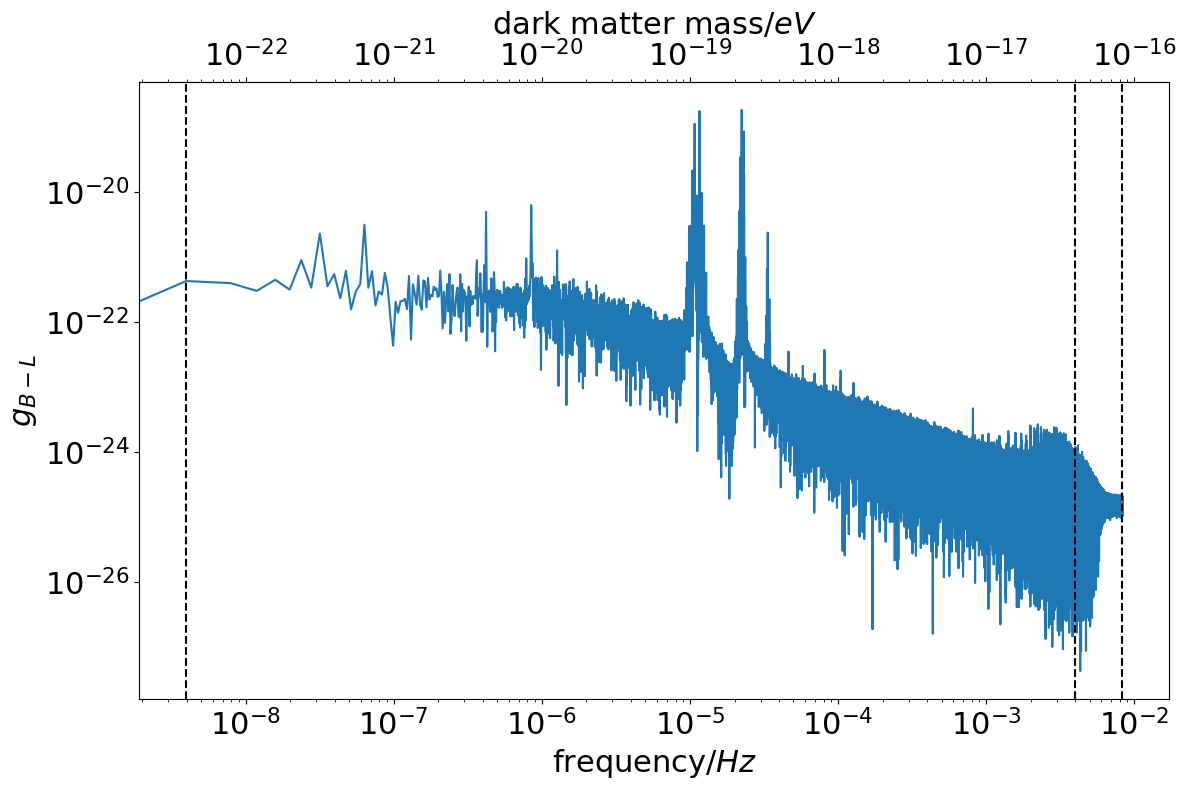

In [15]:
#This is going to use the debil, the pure data

# Compute PSD WITHOUT FILTER
fft_values = np.fft.rfft(debil)
psd_values = np.abs(fft_values) ** 2 / (N * samplingRate)
frequencies = np.fft.rfftfreq(N, d=1/samplingRate)

# Assign PSD values to S and frequencies to freq
S = psd_values
freq = frequencies

# Constants
m_neutron = 1.675e-27  # Mass of neutron in kilograms
F_0 = 1e-15

# Do g_B-L transformation

def g_B_L(S, freq):
    T_coherent = 1e6 / freq
    T_integration = 252460680
    T_effective = np.where(T_coherent < T_integration, T_integration, np.sqrt(T_coherent * T_integration))
    return (2 * m_neutron / F_0) * np.sqrt(S * 1e-18 / T_effective)

g = g_B_L(S,freq)

fig, ax1 = plt.subplots(figsize=(12, 8))

# Plotting on the first y-axis and first x-axis
ax1.plot(freq, g, label='y=3e-17')
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlabel(r'frequency$/Hz$', fontsize=22)
ax1.set_ylabel(r'$g_{B-L}$', fontsize=22)
ax1.tick_params('x',labelsize=22)
ax1.tick_params('y',labelsize=22)

# Define forward and inverse transformations for x2 and y2
def forward_x2_transform(x):
    return x * 1e-14

def inverse_x2_transform(x):
    return x / 1e-14

# Create secondary x and y axes
secax_x = ax1.secondary_xaxis('top', functions=(forward_x2_transform, inverse_x2_transform))

# For the secondary x-axis label and tick parameters
secax_x.set_xlabel(r'dark matter mass$/eV$', fontsize=22)
secax_x.tick_params(axis='x', labelsize=22)

# Define cut-off x-axis values
cut_off2 = 1/60 *0.5
cut_off1 = 1/252460680
cut1 = 10**6 / 252460680

# Add vertical dotted lines at cut-off x-axis values
ax1.axvline(cut_off2, color='k', linestyle='--')
ax1.axvline(cut_off1, color='k', linestyle='--')
ax1.axvline(cut1, color='k', linestyle='--')

# Add annotations
ax1.annotate('Sampling Rate Cut-off', xy=(cut_off2, 1e-13), xytext=(1.5*1e-3, 1e5))


plt.tight_layout()  # adjust layout for better appearance
plt.show()
